In [61]:
"20220301"[::-1][:4][::-1]

'0301'

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat May 29 20:36:18 2021

@author: V1: Changhyeon Kim (changhyeon.kim@uga.edu); V2: Andrew Benecchi (Andrew.Benecchi@uga.edu)
@Description: Analyze multispectral images (generate indice images with the averaged values for only canopy area) 
@key reference for the alignment adjustment: https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/
"""
#libraries (no need to change)
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import pandas as pd
import os
from pathlib import Path
import skimage
from skimage import measure
import gc
'''
KEY = dict({'A':0.5, # specific to SENDD project
     'B':1.,
     'C':2.,
     'D':4.,
     'E':8.,
     'F':0.})
'''
#function to adjust alignment of unaliment image
def Img_Alignment(Image_for_alignment,Reference):
    #the referecen: https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/
    #1st parameter -> Image_for_alignment: an image that should be adjusted
    #2nd parameter -> Reference: a reference alignment image for alignment adjustment
    Before = cv2.imread(Image_for_alignment)#Read image that is before the alignment adjustment
    Before_gray = cv2.cvtColor(Before,cv2.COLOR_BGR2GRAY) #convert the image as gray scale
    sz = Reference.shape #find size of the reference image
    warp_mode = cv2.MOTION_TRANSLATION # Define the motion model
    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
        warp_matrix = np.eye(2, 3, dtype=np.float32)
    # Specify the number of iterations.
    number_of_iterations = 5000;
    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC(Reference,Before_gray,warp_matrix, warp_mode, criteria, None, 1)
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
       # Use warpPerspective for Homography
       Aligned = cv2.warpPerspective (Before, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
    # Use warpAffine for Translation, Euclidean and Affine
       Aligned = cv2.warpAffine(Before, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    Aimg=str(Image_for_alignment).replace('.png','') # image name
    cv2.imwrite(Aimg+"_aligned.png",Aligned) #it generates 16 bit images
    
# Index Extractor based on Multispectral Images
#User defined function to creat index image and extract the average and std of the index value over the projected canopy size
def IEMI(minPxs, Histmin, Histmax, spectrum1, spectrum2, csvname, imageformat, folder,align=True,largest_only=False,saveFigs=False,saveArrs=True,saveCSV=False,arrout='',garbage=True):
    path = sorted(glob.glob(folder+"/*/*/"))#directory 
    path = (pd.Series(path) + imageformat).tolist()#find all files in a folder of the directory
    with open(csvname, 'x', newline='') as csvfile:
        pass
    with open(csvname, 'w+', newline='') as csvfile: #to create csv file which will include the data
        writer = csv.DictWriter(csvfile, fieldnames = [
            "File_Name", "Color","Date","Fert_Type","Sample","Fert_Concentration", # specific to SENDD
            "Unique_ID", "Avg_UDI", "Std_UDI", "Avg_ACI", "Std_ACI", "Avg_NDVI", "Std_NDVI", "Avg_CFI", "Std_CFI", "Area"
       ]) #header of each column within the csv file
        writer.writeheader()
          
    for i in path:
        fileList=glob.glob(i)
        pp = Path(i) # get path as iterable
        if i.find('DELETE_ME') != -1:
            print('skipping '+i)
            continue
        else:
            print('working on '+i)
            for fdx, filename in enumerate(fileList): #A For loop statment: iteration from all indices (filenames) within the folder
                #print(filename)
                fname = filename.rsplit(".", 1)[0] #Treating the string into a list following the separator "."
                fname = fname.replace('ch7', '')#remove string that is redundant 
                fname = fname.replace('mask', '')#remove string that is redundant

                if filename.find('mask')!= -1:#mask = Chlorophyll fluorescence image used to generate mask image
                    fn0 = str(fname)
                    CFIimg = cv2.imread(filename) #Define 'CFIimg' that reads an CFI image corresponding to a filename;
                    CFIgray = cv2.cvtColor(CFIimg, cv2.COLOR_BGR2GRAY)#Convert 'CFIimg' as grayscale image
                    CFI_Hist = cv2.calcHist([CFIimg], [0], None, [256], [0,256]) #make a histogram of pixel intensity in CFI image
                    # Find the location in the histogram with the lowest pixel intensity (within a specified range of pixel intensities)
                    # Underlying assumption is that the lowest value between background and plant is somewhere 
                    # at a pixel intensity between 20 and 90. That range can be easily adjusted in the following instruction.
                    # If you change the lower pixel intensity at which to start looking for a minimum, make sure to change that value
                    # both after the '=' sign and in the Hist[xx:90] range.
                    # print(Hist) This instruction can be used to output the histogram
                    Threshold = Histmin + np.argmin(CFI_Hist[Histmin:Histmax])

                    #threshold the grayscaled-image as two channel (black and white) based on threshold values; 'ret': return
                    ret, thres = cv2.threshold(CFIgray, Threshold, 255, cv2.THRESH_BINARY)
                    #The function yields the information of the every seperated components from the thresholded two-channel-image
                    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(thres)
                    #labels: matrix size, stats: the stats in the matrix, centroids: x and y locations within the matrix

                    #CC_STAT_AREA: function to get area from the stats in the components of the image. it can be changed to width or height of the image; please refer https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python
                    areas = stats[1:,cv2.CC_STAT_AREA]#with the 'stats' from the two-channel treshold, area can be calculated.
                    result = np.zeros((labels.shape), np.uint8)#empty matrix, will be used to write the thresholded two-channel image
                    #For loop statement to remove pixels outside of the given range; associated to first two parameter of line 114 
                    for i in range(0, nlabels - 1):    
                        if areas[i] > minPxs: #if the components within the image meets the conditions, keep and others are discarded
                            result[labels == i + 1] = 255 #convert the only components meeting the conditions
                    cv2.imwrite(str(fn0)+"_binary.png",result)#save the binary image in which has white for foreground (region of interest; aka plant canopy) and black for background
                    binary = cv2.imread(fn0+"_binary.png", cv2.IMREAD_GRAYSCALE)#open binary image that will be used to seperate plant canopy and background
                    #
                    if largest_only:
                        labels_mask = measure.label(binary)                       
                        regions = measure.regionprops(labels_mask)
                        regions.sort(key=lambda x: x.area, reverse=True)
                        if len(regions) > 1:
                            for rg in regions[1:]:
                                labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
                        labels_mask[labels_mask!=0] = 255
                        binary = labels_mask
                        cv2.imwrite(fn0+"_binary.png",binary)
                    PCS = cv2.countNonZero(binary) # number of pixels for projected canopy size by counting non-zero values 
                    RCFI = np.where(binary==0, 0, CFIgray) #np.float64(CFIgray) #Generate intensity value (R; proxy of reflectance) of CFI in a float64 format from CFI image in a grayscale
                elif filename.find("ch0") != -1:#ch0 = 450 nm; Only find an image including the "ch0"
                    Pch0 = cv2.imread(filename, cv2.IMREAD_GRAYSCALE) #Read the spectral image at 450nm and define it as Pch0;
                    R450 = np.float64(Pch0) #generate R450 objects as arrays in float64 format from Pch0; 
                    #R is intensity that is proxy of reflectance
                elif filename.find('ch1')!= -1:#ch1 = 521 nm
                    Pch1 = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                    R521 = np.float64(Pch1)
                elif filename.find('ch2')!= -1:#ch2 = 593 nm
                    Pch2 = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                    R593 = np.float64(Pch2) 
                elif filename.find('ch3')!= -1:#ch3 = 625 nm
                    Pch3 = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                    R625 = np.float64(Pch3)  
                elif filename.find('ch4')!= -1:#ch4 = 660 nm
                    Pch4 = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)#cv2.imread(filename+"_aligned.jpg",cv2.IMREAD_ANYDEPTH)
                    R660 = np.float64(Pch4) 
                elif filename.find('ch5')!= -1:#ch5 = 730 nm
                    Pch5 = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                    R730 = np.float64(Pch5)
                elif filename.find('ch6.png')!= -1:#ch6 = 870 nm, here the program fix the alignment
                    if align: # if image needs alignment
                        Img_Alignment(filename,CFIgray) # align image and save file
                        Pch6 = cv2.imread(fname+"_aligned.png",cv2.IMREAD_ANYDEPTH) # open 16 bit image (the aligned image)
                        # as 8 bit image
                    else:
                        Pch6 = cv2.imread(filename,cv2.IMREAD_GRAYSCALE) # else read normally
                    R870 = np.float64(Pch6) 
            if saveFigs:
                #Plot a histogram of CFI
                plt.plot(CFI_Hist), plt.yscale('log'), plt.xlabel('Intensity'), plt.ylabel('Pixel frequency (log)'), plt.title('CFI intensity and frequency'), plt.savefig(str(fn0)+"_histogram.jpg"), plt.close()
            Avg_CFI = np.mean(RCFI[RCFI>=Threshold]) #averaged value of CFI intensity of plant
            Std_CFI = np.std(RCFI[RCFI>=Threshold]) #standard deviation of CFI intensity of plant
            #the condition in bracket is to remove background in chlorophyll fluorescence image  
            if garbage:
                del RCFI, CFIgray
            #Calculate User Defined Index (UDI) in which is based on idx_intensity 1 and 2; user can put any spectrum for index calculation.
            sptr_1 = eval(spectrum1) #read the input and remove the quotation marks
            sptr_2 = eval(spectrum2) 
            with np.errstate(divide='ignore'):# to ignore zero values of denominator during the index calculation
                UDI_before_masking = np.true_divide(np.subtract(sptr_1,sptr_2), np.add(sptr_1,sptr_2)) #+1#to have unique values between the object and background 
            #remove the background by conjugating foreground (ACI image) and the background (binary image for object of interest) 
            #print(UDI_before_masking.shape)
            #UDI = cv2.bitwise_and(UDI_before_masking, UDI_before_masking, mask=binary)#mask contains 1 or 0, where 1 is the object of interet and 0 is background
            UDI = np.where(binary == 0, -1, UDI_before_masking)#replace the background value, 0, as -1 to have better contrast between background and the object of interest
            #UDI = np.where(UDI != -1, UDI-1, UDI)#after the separation between the object and background, subtract 1 again to have the orginial index value
            # Get Histogram Weights
            UDI_Hist = UDI[UDI !=-1]#remove the background, which has value of -1
            #plt.imshow(UDI)
            #break
            #print(UDI)
            #print(saveArrs)
            print(pp.parent)
            if arrout == '':
                par = pp.parent
                arrnm = os.path.join(str(par),
                    str(pp.parts[-2])
                                ) # get new, more readable array filename
            else:
                par = arrout
                arrnm = os.path.join(str(par),
                    str(pp.parts[-5])+'_'+str(pp.parts[-4])+'_'+str(pp.parts[-3])
                                ) # get new, more readable array filename
            print(arrnm)
            # 1/0 #used as break
            if saveArrs==True:
                print('saving '+str(arrnm)+"_UDI.npy")
                np.save(str(arrnm)+"_UDI.npy",UDI)
            if saveFigs:
                plt.savefig(str(fn0)+"_UDI.png", dpi = 300) #save the UDI image in the directory of where the image is located
                try:
                    os.remove(str(fn0)+"_UDI.jpg") # remove jpg
                except:
                    pass
                        # Plot a picture of UDI
                plt.colorbar(plt.imshow(UDI), fraction = 0.046, pad=0.04)# to generate a color scale bar
                plt.clim(-1,1)#range of the color gradient for normalized index image
                plt.axis('off') #Not to show the axis info of the image
                plt.close() #close the UDI image
                #Plot a histogram of UDI

                UDI_weights = np.ones_like(UDI_Hist)/float(len(UDI_Hist))#nomarlize the values in histogram
                plt.hist(UDI_Hist, weights=UDI_weights, bins=300, rwidth =0.85)
                plt.xlabel('User defined index ('+spectrum1+','+spectrum2+')')#put a label on x-axis
                plt.ylabel('Pixel Proportion (% of total)')#put a label on y-axis
                plt.title('Canopy User defined index') #title of the histogram
                plt.savefig(str(fn0)+"_UDI_HIST.jpg", dpi = 300) #save the Histogram in the directory of where the image is located
                plt.close() #close the histogram
            Avg_UDI = np.mean(UDI_Hist) #averaged value from the histogram
            Std_UDI = np.std(UDI_Hist) #standard deviation from the histogram
            if garbage:
                del UDI, UDI_Hist    
            #Calculate Anthocyanin content index; these calculation need float64 format
            with np.errstate(divide='ignore'):# to ignore zero values of denominator during the index calculation
                ACI_before_masking = np.true_divide(np.subtract(R660,R521), np.add(R660,R521)) #+1#to have unique values between the object and background 
            #remove the background by conjugating foreground (ACI image) and the background (binary image for object of interest) 
            #ACI = cv2.bitwise_and(ACI_before_masking, ACI_before_masking, mask=binary)#mask contains 1 or 0, where 1 is the object of interet and 0 is background
            ACI = np.where(binary == 0, -1, ACI_before_masking)#replace the background value, 0, as -1 to have better contrast between background and the object of interest
            #ACI = np.where(ACI != -1, ACI-1, ACI)#after the separation between the object and background, subtract 1 again to have the orginial index value
            # Get Histogram Weights
            ACI_Hist = ACI[ACI !=-1]#remove the background, which has value of -1
            if saveArrs==True:
                print('saving '+str(arrnm)+"_ACI.npy")
                np.save(str(arrnm)+"_ACI.npy",ACI) # save npy file
            if saveFigs:
                # Plot a picture of ACI
                plt.colorbar(plt.imshow(ACI), fraction = 0.046, pad=0.04)# to generate a color scale bar
                plt.clim(-1,1)#range of the color gradient for normalized index image
                plt.axis('off') #Not to show the axis info of the image
                plt.savefig(str(fn0)+"_ACI.png", dpi = 300) #save the ACI image in the directory of where the image is located
                try:
                    os.remove(str(fn0)+"_ACI.jpg") # remove .jpg
                except:
                    pass
                plt.close() #close the ACI image
                #Plot a histogram of ACI
                ACI_weights = np.ones_like(ACI_Hist)/float(len(ACI_Hist))
                plt.hist(ACI_Hist, weights=ACI_weights, bins=300, rwidth =0.85)
                plt.xlabel('Anthocyanin Content Index')#put a label on x-axis
                plt.ylabel('Pixel Proportion (% of total)')#put a label on y-axis
                plt.title('Canopy Anthocyanin Content Index') #title of the histogram
                plt.savefig(str(fn0)+"_ACI_HIST.jpg", dpi = 300) #save the Histogram in the directory of where the image is located
                plt.close() #close the histogram
            Avg_ACI = np.mean(ACI_Hist) #averaged value from the histogram
            Std_ACI = np.std(ACI_Hist) #standard deviation from the histogram
            if garbage:
                del ACI, ACI_Hist
            #Calculate Normalized difference vegetation index
            with np.errstate(divide='ignore'):# to ignore zero values of denominator during the index calculation
            #NDVI calculation (R660 - R521)/(R660+R521), where R is reflectance value extracted from the multipsectral images
                NDVI_before_masking = np.true_divide(np.subtract(R870,R660), np.add(R870,R660)) #+1#to have unique values between the object and background 
            #remove the background by conjugating foreground (NDVI image) and the background (binary image for object of interest) 
            #NDVI = cv2.bitwise_and(NDVI_before_masking,NDVI_before_masking, mask=binary)#mask contains 1 or 0, where 1 is the object of interet and 0 is background
            NDVI = np.where(binary == 0, -1, NDVI_before_masking)#replace the background value, 0, as -1 to have better contrast between background and the object of interest
            #NDVI = np.where(NDVI != -1, NDVI-1, NDVI)#after the separation between the object and background, subtract 1 again to have the orginial index value
            if saveArrs==True:
                print('saving '+str(arrnm)+"_NDVI.npy")
                np.save(str(arrnm)+"_NDVI.npy",NDVI) # save npy array
            if saveFigs:
                # Plot a picture of NDVI
                plt.colorbar(plt.imshow(NDVI), fraction = 0.046, pad=0.04)# to generate a color scale bar
                plt.clim(0,1)#range of the color gradient for normalized index image
                plt.axis('off') #Not to show the axis info of the image
                plt.savefig(str(fn0)+"_NDVI.png", dpi = 300) #save the NDVI image in the directory of where the image is located
                try:
                    os.remove(str(fn0)+"_NDVI.jpg")# remove .jpg
                except:
                    pass
                plt.close() #close the NDVI image
            #Plot a histogram of NDVI
            NDVI_Hist = NDVI[NDVI !=-1]#remove the background, which has value of -1
            NDVI_weights = np.ones_like(NDVI_Hist)/float(len(NDVI_Hist))
            if saveFigs:
                plt.hist(NDVI_Hist, weights=NDVI_weights, bins=300, rwidth =0.85)
                plt.xlabel('NDVI')#put a label on x-axis
                plt.ylabel('Pixel Proportion (% of total)')#put a label on y-axis
                plt.title('Canopy NDVI') #title of the histogram
                plt.savefig(str(fn0)+"_NDVI_HIST.jpg", dpi = 300) #save the Histogram in the directory of where the image is located
                plt.close() #close the histogram
            Avg_NDVI = np.mean(NDVI_Hist) #averaged value from the histogram
            Std_NDVI = np.std(NDVI_Hist) #standard deviation from the histogram
            if gc:
                del NDVI, NDVI_Hist
            if saveCSV:
                #write the information into a given csv file name
                with open(csvname, "a", newline='') as csvfile: 
                    writer = csv.writer(csvfile)
                    col = pp.parts[-5] # specific to SENDD project
                    dat = pp.parts[-2][2:6]+'-'+pp.parts[-4][:2]+"-"+pp.parts[-4][2:] # specific to SENDD project
                    let = pp.parts[-3][0] # specific to SENDD project
                    smp = pp.parts[-3][1:] # specific to SENDD project
                    IDX = pp.parts[-5]+'_'+pp.parts[-3] # specific to SENDD project
                    writer.writerow([
                        arrnm,col,dat,let,smp,KEY[let],IDX, # specific to SENDD
                                     Avg_UDI, Std_UDI, Avg_ACI, Std_ACI, Avg_NDVI, Std_NDVI, Avg_CFI, Std_CFI, PCS
                                     ])
                # IF THE ABOVE LINE GIVES AN ERROR MESSAGE, REPLACE WRITEROW WITH WRITE. THE CORRECT FORMAT APPEARS TO DEPENDS ON THE VERSION OF THE OpenCV package
                csvfile.close()
            print('done with '+arrnm) #+'. Collecting garbage...')
            #if garbage:
            #    gc.collect()
            

        

#IEMI(minPxs, Histmin, Histmax, spectrum1, spectrum2, csvname, imageformat, folder): 
#For 'spectrum1' and 'spectrum2', type one of "RCFI", "R450", "R521", "R593", "R625", "R660", "R730", and "R870"      
#IEMI(500, 10, 30, "R593", "R521", "D:/Petunias/Until 3-18/Blue/Mar 26/result.csv",'/*.png',"D:/Petunias/Until 3-18/Blue/Mar 26/*")
IEMI(500, 10, 30, "R593", "R521", "F:/petunias_final.csv",'*.png',"F:/Petunia Images/*/*/",largest_only=True,saveFigs=False,
     saveArrs=True,saveCSV=True,arrout='F:/New_Pickles')
#IEMI(minPxs, Histmin, Histmax, spectrum1, spectrum2, csvname, imageformat, folder,saveFigs=False,saveArrs=True,saveCSV=False)




working on F:/Petunia Images\Blue\0301\A1\tv20220302_074106\*.png
F:\Petunia Images\Blue\0301\A1\tv20220302_074106
F:/New_Pickles\Blue_0301_A1
saving F:/New_Pickles\Blue_0301_A1_UDI.npy
saving F:/New_Pickles\Blue_0301_A1_ACI.npy
saving F:/New_Pickles\Blue_0301_A1_NDVI.npy
done with F:/New_Pickles\Blue_0301_A1
working on F:/Petunia Images\Blue\0301\A2\tv20220302_074457\*.png
F:\Petunia Images\Blue\0301\A2\tv20220302_074457
F:/New_Pickles\Blue_0301_A2
saving F:/New_Pickles\Blue_0301_A2_UDI.npy
saving F:/New_Pickles\Blue_0301_A2_ACI.npy
saving F:/New_Pickles\Blue_0301_A2_NDVI.npy
done with F:/New_Pickles\Blue_0301_A2
working on F:/Petunia Images\Blue\0301\A3\tv20220302_074520\*.png
F:\Petunia Images\Blue\0301\A3\tv20220302_074520
F:/New_Pickles\Blue_0301_A3
saving F:/New_Pickles\Blue_0301_A3_UDI.npy
saving F:/New_Pickles\Blue_0301_A3_ACI.npy
saving F:/New_Pickles\Blue_0301_A3_NDVI.npy
done with F:/New_Pickles\Blue_0301_A3
working on F:/Petunia Images\Blue\0301\A4\tv20220302_074044\*.png
F

<ipython-input-2-45ca07e924a2>:218: RuntimeWarning: invalid value encountered in divide
  ACI_before_masking = np.true_divide(np.subtract(R660,R521), np.add(R660,R521)) #+1#to have unique values between the object and background


saving F:/New_Pickles\Blue_0323_E2_ACI.npy
saving F:/New_Pickles\Blue_0323_E2_NDVI.npy
done with F:/New_Pickles\Blue_0323_E2
working on F:/Petunia Images\Blue\0323\E3\tv20220323_230646\*.png
F:\Petunia Images\Blue\0323\E3\tv20220323_230646
F:/New_Pickles\Blue_0323_E3
saving F:/New_Pickles\Blue_0323_E3_UDI.npy
saving F:/New_Pickles\Blue_0323_E3_ACI.npy
saving F:/New_Pickles\Blue_0323_E3_NDVI.npy
done with F:/New_Pickles\Blue_0323_E3
working on F:/Petunia Images\Blue\0323\E4\tv20220323_223136\*.png
F:\Petunia Images\Blue\0323\E4\tv20220323_223136
F:/New_Pickles\Blue_0323_E4
saving F:/New_Pickles\Blue_0323_E4_UDI.npy
saving F:/New_Pickles\Blue_0323_E4_ACI.npy
saving F:/New_Pickles\Blue_0323_E4_NDVI.npy
done with F:/New_Pickles\Blue_0323_E4
working on F:/Petunia Images\Blue\0323\E5\tv20220323_224420\*.png
F:\Petunia Images\Blue\0323\E5\tv20220323_224420
F:/New_Pickles\Blue_0323_E5
saving F:/New_Pickles\Blue_0323_E5_UDI.npy
saving F:/New_Pickles\Blue_0323_E5_ACI.npy
saving F:/New_Pickles\Bl

<ipython-input-2-45ca07e924a2>:164: RuntimeWarning: invalid value encountered in divide
  UDI_before_masking = np.true_divide(np.subtract(sptr_1,sptr_2), np.add(sptr_1,sptr_2)) #+1#to have unique values between the object and background


F:\Petunia Images\Blue\0326\E5\tv20220327_055059
F:/New_Pickles\Blue_0326_E5
saving F:/New_Pickles\Blue_0326_E5_UDI.npy
saving F:/New_Pickles\Blue_0326_E5_ACI.npy
saving F:/New_Pickles\Blue_0326_E5_NDVI.npy
done with F:/New_Pickles\Blue_0326_E5
working on F:/Petunia Images\Blue\0326\E6\tv20220327_053505\*.png
F:\Petunia Images\Blue\0326\E6\tv20220327_053505
F:/New_Pickles\Blue_0326_E6
saving F:/New_Pickles\Blue_0326_E6_UDI.npy
saving F:/New_Pickles\Blue_0326_E6_ACI.npy
saving F:/New_Pickles\Blue_0326_E6_NDVI.npy
done with F:/New_Pickles\Blue_0326_E6
working on F:/Petunia Images\Blue\0326\E7\tv20220327_053631\*.png
F:\Petunia Images\Blue\0326\E7\tv20220327_053631
F:/New_Pickles\Blue_0326_E7
saving F:/New_Pickles\Blue_0326_E7_UDI.npy
saving F:/New_Pickles\Blue_0326_E7_ACI.npy
saving F:/New_Pickles\Blue_0326_E7_NDVI.npy
done with F:/New_Pickles\Blue_0326_E7
working on F:/Petunia Images\Blue\0326\E8\tv20220327_052047\*.png
F:\Petunia Images\Blue\0326\E8\tv20220327_052047
F:/New_Pickles\Blu

In [4]:
f0 = pd.read_csv('F:/petunias_new.csv')
f1 = pd.read_csv('F:/petunias_final.csv')


In [28]:
f0.iloc[(f0['Area']-f1['Area']).sort_values().index[::-1][0],:]

File_Name             /mnt/f/Pickles/Purple_0319_E6
Color                                        Purple
Date                                      3/19/2022
Fert_Type                                         E
Replicate                                         6
Fert_Concentration                                8
Unique_ID                                 Purple_E6
Avg_UDI                                    0.029224
Std_UDI                                   0.0574583
Avg_ACI                                   -0.128855
Std_ACI                                   0.0837589
Avg_NDVI                                    0.65063
Std_NDVI                                  0.0942625
Avg_CFI                                     54.8329
Std_CFI                                     11.7792
Area                                        1704191
Name: 565, dtype: object

File_Name             /mnt/f/Pickles/Purple_0319_E6
Color                                        Purple
Date                                      3/19/2022
Fert_Type                                         E
Replicate                                         6
Fert_Concentration                                8
Unique_ID                                 Purple_E6
Avg_UDI                                    0.029224
Std_UDI                                   0.0574583
Avg_ACI                                   -0.128855
Std_ACI                                   0.0837589
Avg_NDVI                                    0.65063
Std_NDVI                                  0.0942625
Avg_CFI                                     54.8329
Std_CFI                                     11.7792
Area                                        1704191
Name: 565, dtype: object

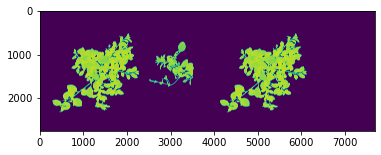

In [31]:
img1 = np.load(f0.iloc[(f0['Area']-f1['Area']).sort_values().index[::-1][0],0].replace('/mnt/f','F:')+'_NDVI.npy')
img2 = np.load(f1.iloc[(f0['Area']-f1['Area']).sort_values().index[::-1][0],0].replace('/mnt/f','F:')+'_NDVI.npy')
imgc = np.hstack([img1,img2])
plt.imshow(imgc)
f0.iloc[(f0['Area']-f1['Area']).sort_values().index[::-1][0],:]